In [1]:
library(dplyr, warn=F)
library(ggplot2)

In [2]:
# Read 2014 SJR values
metric_df = 'https://github.com/dhimmel/journalmetrics/raw/fb6797b680ff6d119ef21de8791c0573d44cf6c0/data/pubmed-metrics.tsv.gz' %>%
  readr::read_tsv() %>%
  dplyr::filter(year == 2014, metric == 'SJR') %>%
  dplyr::transmute(journal_nlm_id, sjr = value)

head(metric_df, 2)

,journal_nlm_id,sjr
1,0000266,0.589
2,0001027,0.753


In [3]:
# Read journal delay slopes
slope_df = 'data/slopes.tsv' %>%
  readr::read_tsv() %>%
  dplyr::inner_join(metric_df)

head(slope_df, 2)

Joining by: "journal_nlm_id"


,journal_nlm_id,articles,slope,slope_as_percent,p_value,delay_type,sjr
1,0111356,163,-473.2081,-368.4048,2.48e-28,publish,0.389
2,101128940,152,-218.7405,-144.2829,4.92e-10,publish,0.162


In [4]:
# Read median journal delays
delay_df = 'data/journal-summaries.tsv' %>%
  readr::read_tsv() %>%
  dplyr::select(journal_nlm_id, median_acceptance_delay, median_publication_delay) %>%
  tidyr::gather(key=delay_type, value=delay, median_acceptance_delay, median_publication_delay) %>%
  dplyr::mutate(delay_type = c(median_acceptance_delay='accept', median_publication_delay='publish')[delay_type]) %>%
  dplyr::inner_join(metric_df)

Joining by: "journal_nlm_id"


Warning message:
: Removed 679 rows containing non-finite values (stat_summary).Warning message:
In grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : conversion failure on 'Δ days per year' in 'mbcsToSbcs': dot substituted for <ce>Warning message:
In grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : conversion failure on 'Δ days per year' in 'mbcsToSbcs': dot substituted for <94>Warning message:
In grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : conversion failure on 'Δ days per year' in 'mbcsToSbcs': dot substituted for <ce>Warning message:
In grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : conversion failure on 'Δ days per year' in 'mbcsToSbcs': dot substituted for <94>Warning message:
In grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : conversion failure on 'Δ days per year' in 'mbcsToSbcs': dot substituted for <ce>Warning message:
In grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : conversion failur

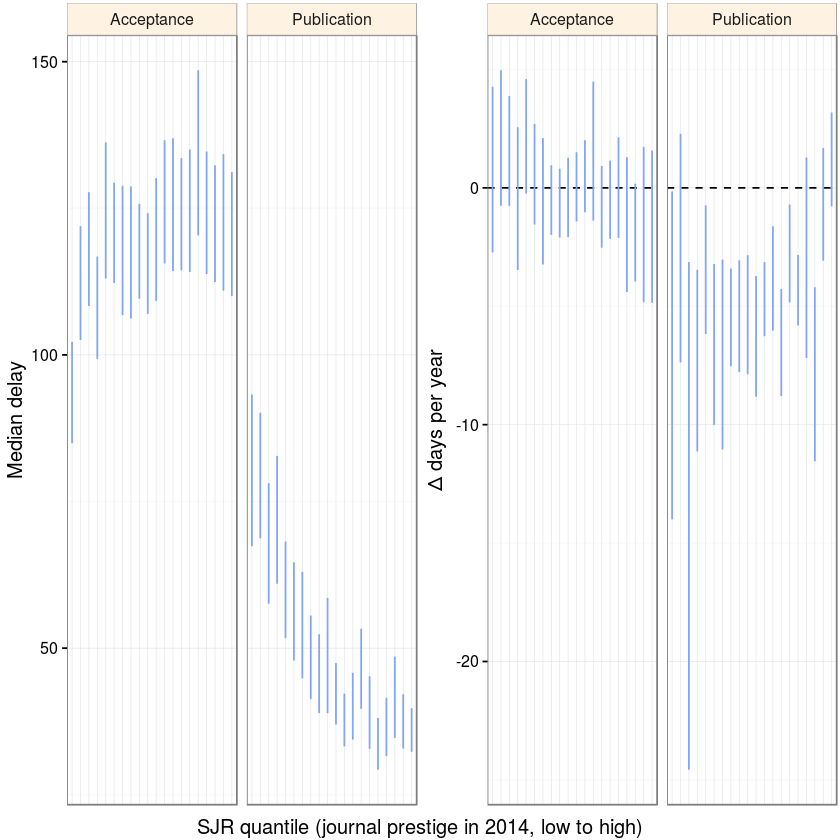

In [5]:
mean_CI <- function(x) {t.test(x)$conf.int[1:2]}

n_quantiles = 20

format_gg <- function(gg) {
  gg = gg + 
  ggplot2::facet_grid(. ~ delay_type, scales='free_x') +
  ggplot2::stat_summary(fun.data = 'mean_cl_normal', geom = 'errorbar', width = 0, color = '#80a5f9') +
  ggplot2::theme_bw() +
  ggplot2::theme(plot.margin=grid::unit(c(2, 2, 2, 2), 'points')) +
  ggplot2::theme(axis.ticks.x = element_blank(), axis.text.x = element_blank()) +
  ggplot2::theme(strip.background = element_rect(fill = '#fef2e2')) +
  ggplot2::scale_x_discrete(name=NULL)
  return(gg)
}

delay_converter = c(accept='Acceptance', publish='Publication')

gg_delay = delay_df %>%
  dplyr::mutate(delay_type = delay_converter[delay_type]) %>%
  dplyr::mutate(sjr_quantile = dplyr::ntile(sjr, n = n_quantiles)) %>%
  ggplot2::ggplot(aes(x = sjr_quantile, y = delay)) %>%
  format_gg() +
  ggplot2::ylab('Median delay')

gg_slope = slope_df %>%
  dplyr::mutate(delay_type = delay_converter[delay_type]) %>%
  dplyr::mutate(sjr_quantile = dplyr::ntile(sjr, n = n_quantiles)) %>%
  ggplot2::ggplot(aes(x = sjr_quantile, y = slope)) +
  ggplot2::geom_hline(yintercept = 0, linetype = 'dashed')
gg_slope = format_gg(gg_slope) +
  ggplot2::ylab('Δ days per year')

gg = gridExtra::grid.arrange(gg_delay, gg_slope, nrow=1, bottom = 'SJR quantile (journal prestige in 2014, low to high)')
path = file.path('viz', 'impact.png')
ggplot2::ggsave(filename = path, plot = gg, width = 5.5, height = 2.1)